In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import set_config
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
import seaborn as sns
sns.set()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the data into panda data frame

In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv")

# Exploring the data

In [4]:
df.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 422.5 KB


**Nice no object feature**

In [6]:
df.describe()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,2703.000000,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,1561.010784,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,0.000000,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,1351.500000,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,2703.000000,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,4054.500000,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,5406.000000,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


# Dropping the id column

In [7]:
df.drop(labels="id", axis=1, inplace=True)

# Visualizing Data

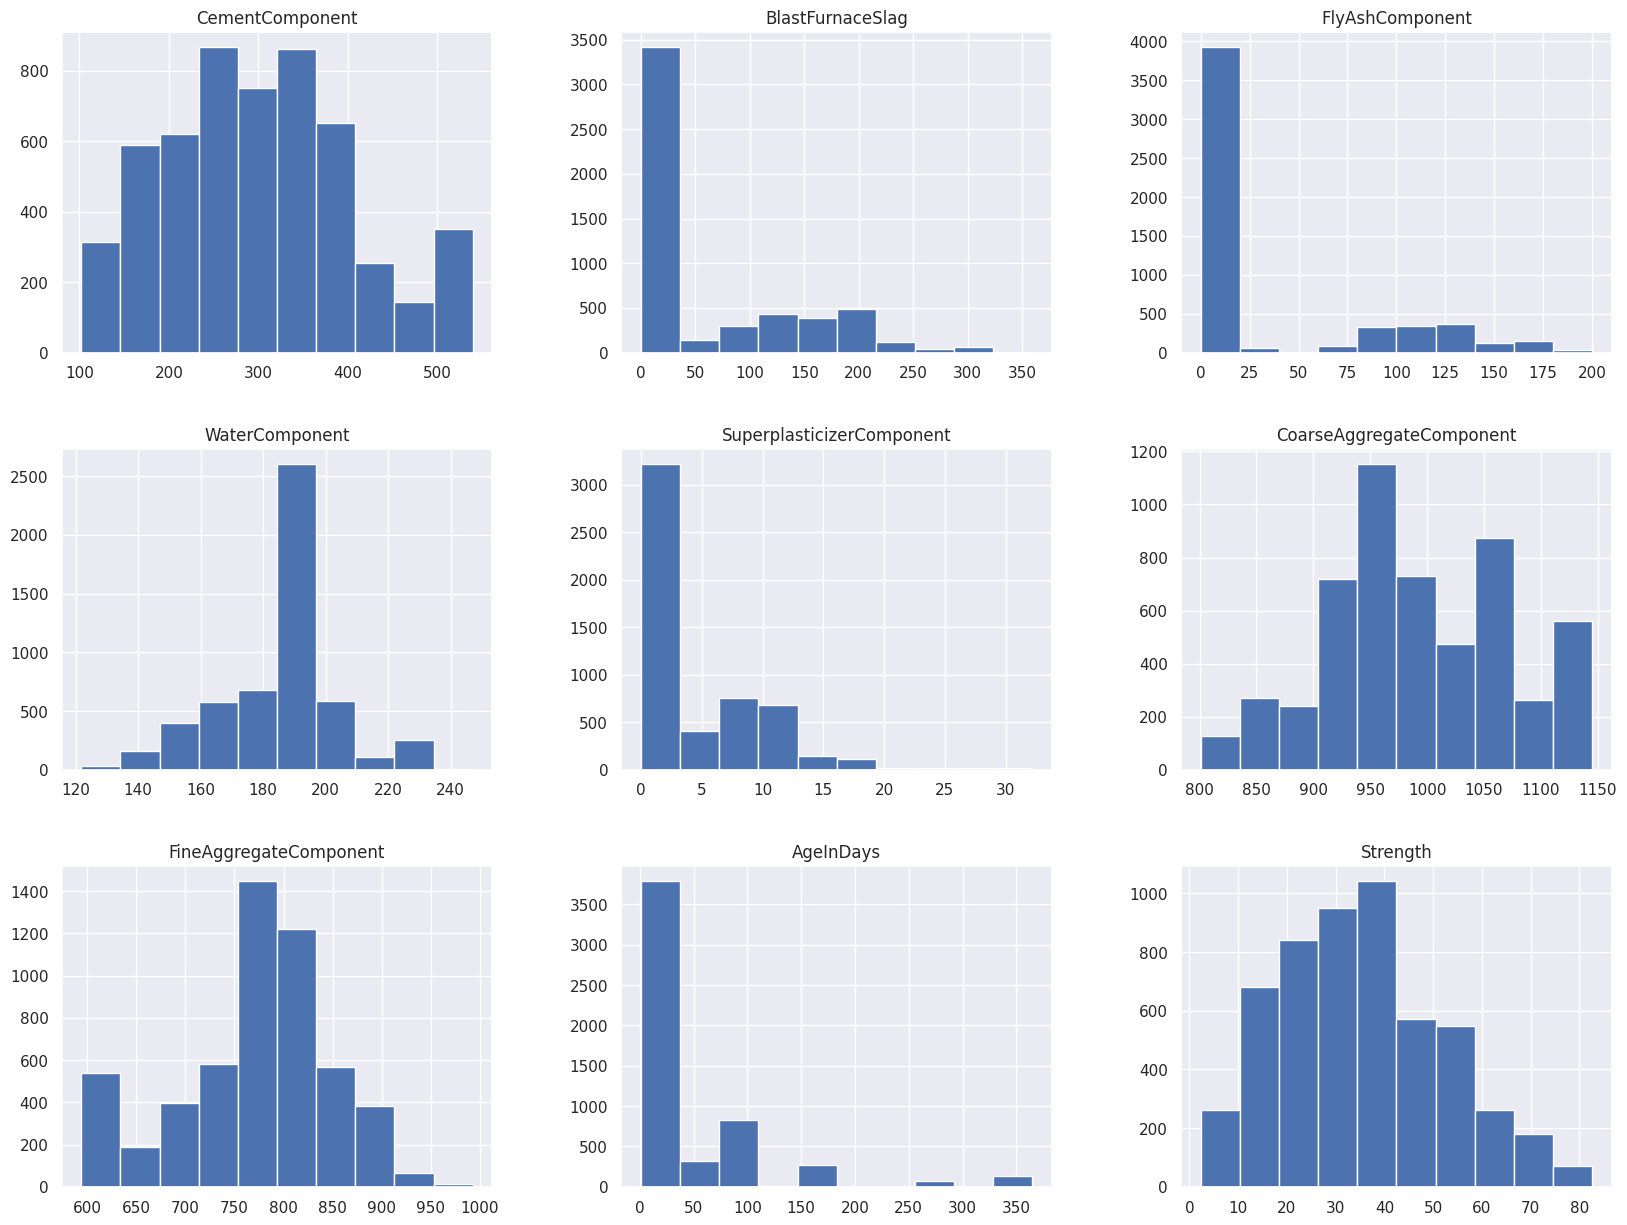

In [8]:
df.hist(figsize=(20,15))
plt.show()

# Looking for co-relations

In [9]:
corr_matrix = df.corr()

In [10]:
corr_matrix["Strength"].sort_values(ascending=False)

Strength                     1.000000
AgeInDays                    0.334204
SuperplasticizerComponent    0.208249
CementComponent              0.158000
BlastFurnaceSlag             0.057506
FlyAshComponent              0.031606
FineAggregateComponent      -0.073900
CoarseAggregateComponent    -0.098410
WaterComponent              -0.113678
Name: Strength, dtype: float64

**Plotting the co-relations**
- From the co-relation matrix we can see that,
- AgeInDays, SuperplasticizerComponent, CementComponent and WaterComponent
- have some good impact on cement strength.
- AgeInDays, SuperplasticizerComponent, CementComponent have positive impact where,
- WaterComponent have negative impact

In [11]:
attr = ["Strength", "AgeInDays", "SuperplasticizerComponent", "WaterComponent"]

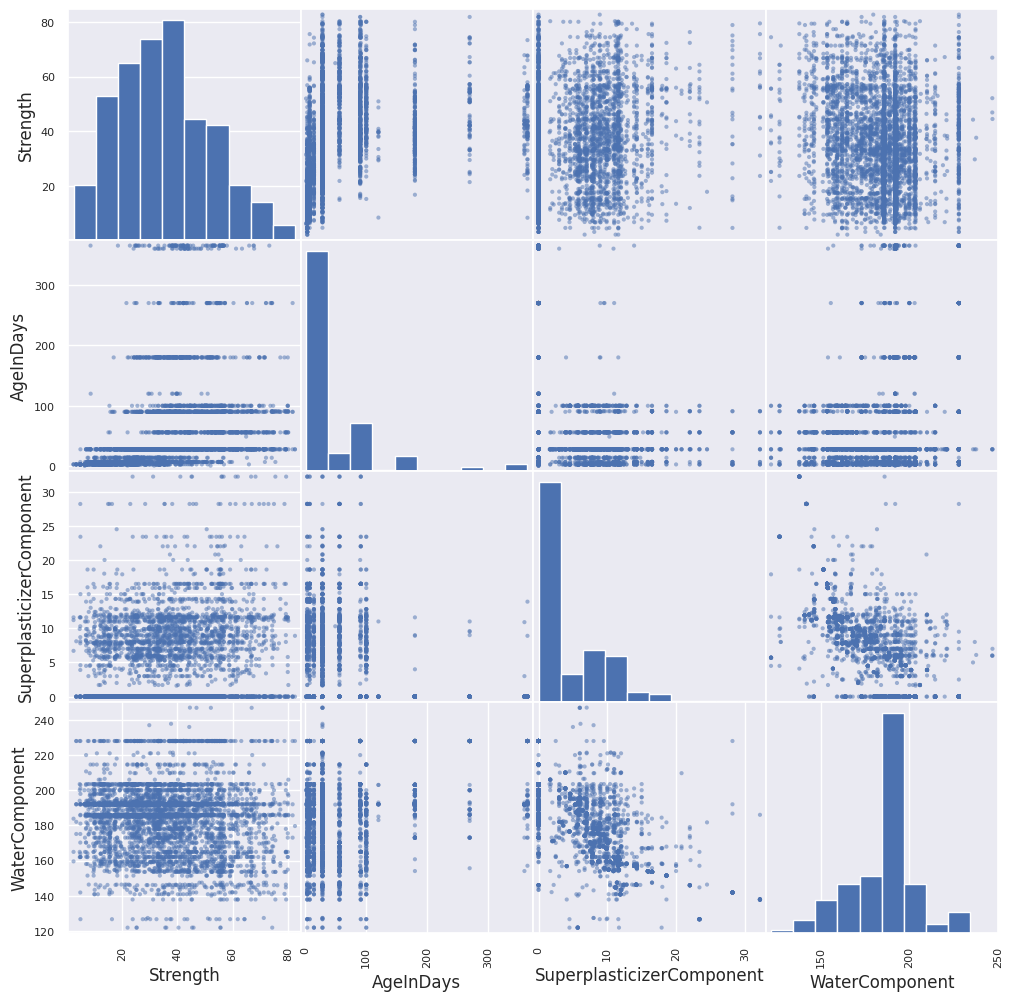

In [12]:
scatter_matrix(df[attr], figsize=(12,12))
plt.show()

**Not so useful insights**

### Correlation to each other

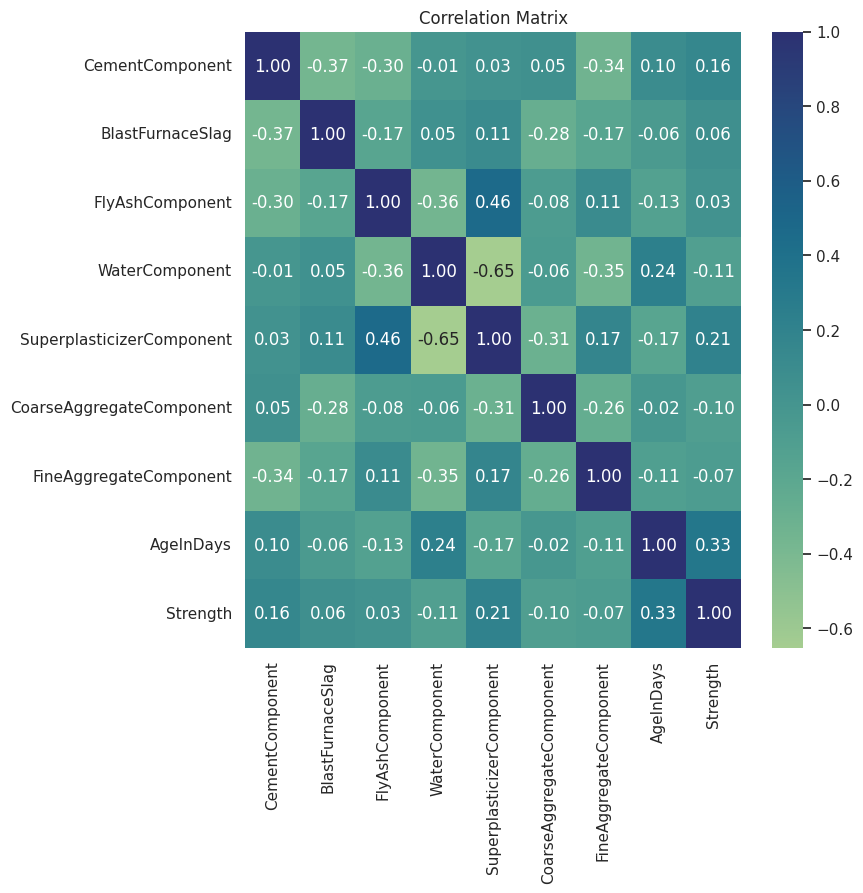

In [13]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, cbar=True, fmt=".2f", cmap="crest")
plt.title("Correlation Matrix")
plt.show()

# Train test split

In [14]:
X_train, X_test, y_train , y_test = train_test_split(df.drop("Strength", axis=1), df["Strength"],
                                     test_size=0.2, random_state=42)

# Scaling the data
- As our data only have numerical data
- we don't need to do much
- we will just scale our data and send it to our model.

In [15]:
scaler = StandardScaler()

In [16]:
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
X_train_scaled

array([[-0.20958166, -0.70254477,  1.2016555 , ..., -0.23679733,
         1.32978384, -0.34002616],
       [ 1.1896904 ,  0.57342281, -0.58087946, ..., -0.7267959 ,
         0.41528822, -0.63798249],
       [ 0.59932815,  1.56610878, -0.58087946, ..., -0.61431601,
        -0.19395156,  0.55384284],
       ...,
       [ 2.27769774, -0.70254477, -0.58087946, ...,  1.71673257,
        -2.00768001, -0.63798249],
       [ 1.8992604 ,  1.1339843 , -0.58087946, ...,  1.71673257,
        -2.01022381,  1.81661015],
       [-0.12254107,  1.70894993, -0.58087946, ...,  0.16011444,
         0.41528822, -0.63798249]])

# Select and train model

In [18]:
# function to show scores
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

**Random Forest**

In [19]:
forest = RandomForestRegressor()
forest.fit(X_train_scaled, y_train)
forest_scores = cross_val_score(forest, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10)
display_scores(np.sqrt(-forest_scores))

Scores:  [12.93112122 13.10515737 13.30309819 13.26080356 12.08754507 13.30501495
 12.95357006 13.02062488 13.6213401  12.98208893]
Mean:  13.057036433222013
Standard deviation:  0.38180248832248453


**Support Vector**

In [20]:
svr = SVR()
svr.fit(X_train_scaled, y_train)
svr_scores = cross_val_score(svr, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10)
display_scores(np.sqrt(-svr_scores))

Scores:  [13.69731444 13.95581334 13.70958148 13.80676734 13.38030481 13.62921539
 13.60975302 13.4094512  13.58916853 13.47860859]
Mean:  13.626597815994298
Standard deviation:  0.16856343231376955


# Fine tune model
**Grid Search**

In [21]:
param_grid = [
    {"n_estimators": [10, 30, 60, 80], "max_features": [8, 12, 20]},
    {"bootstrap": [False], "n_estimators": [10, 30, 50], "max_features": [8, 12]}
]

In [22]:
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)

In [23]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 12, 20],
                          'n_estimators': [10, 30, 60, 80]},
                         {'bootstrap': [False], 'max_features': [8, 12],
                          'n_estimators': [10, 30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
grid_search.best_params_

{'max_features': 12, 'n_estimators': 60}

In [25]:
model = grid_search.best_estimator_

# Data Pipeline
- For data pre processing we will use standard scaler
- For model we will use Random Forest

In [26]:
pipeline = Pipeline([
    ("std_scaler", scaler),
    ("model", model)
])

In [27]:
set_config(display="diagram")
pipeline

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_features=12, n_estimators=60))])

# Testing model

In [28]:
y_pred = pipeline.predict(X_test)

In [29]:
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

12.627671449918347

# Submission

In [30]:
test_df = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv")
test_df_x = test_df.drop(labels="id", axis=1)

In [31]:
final_pred = pipeline.predict(test_df_x)
df = pd.DataFrame({'id': test_df['id'], 'Strength':final_pred})
df.to_csv('submission.csv',index= False)

In [32]:
sub = pd.read_csv("/kaggle/working/submission.csv")
sub.head()

,id,Strength
0,5407,50.889750
1,5408,19.098978
2,5409,33.950740
3,5410,48.665400
4,5411,28.862667
